In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import torch
import os
from datetime import datetime
import pickle

env = gym.make("FrozenLake-v1", render_mode="rgb_array")
q_table = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def visualize_agent(env, q_table, episodes=5, sleep_time=0.5, end_sleep_time=2):
    for _ in range(episodes):
        state, _ = env.reset()
        done = False

        while not done:
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.axis('off')
            plt.show()
            sleep(sleep_time)

            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)

        clear_output(wait=True)
        plt.imshow(env.render())
        plt.axis('off')
        plt.show()
        sleep(end_sleep_time)

In [8]:

# Prepare model saving directories
model_root = "models"
if not os.path.exists(model_root):
    os.makedirs(model_root, exist_ok=True)
try:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
except Exception as e:
    print(f"Error generating timestamp: {e}")
    timestamp = "default_timestamp"
# Load the most recent q_table, ep_num, epsilon, and rewards_per_episode if they exist
latest_data = None
timestamps = [d for d in os.listdir(model_root) if os.path.isdir(os.path.join(model_root, d))]
if timestamps:
    latest_timestamp = max(timestamps)
    latest_run_dir = os.path.join(model_root, latest_timestamp)
    dump_files = [f for f in os.listdir(latest_run_dir) if f.endswith(".pkl") or f.endswith(".pt")]
    if dump_files:
        latest_dump_file = max(dump_files, key=lambda x: int(x.split('_')[1]))
        latest_dump_path = os.path.join(latest_run_dir, latest_dump_file)
        if latest_dump_path.endswith(".pkl"):
            with open(latest_dump_path, "rb") as f:
                latest_data = pickle.load(f)
        elif latest_dump_path.endswith(".pt"):
            latest_data = torch.load(latest_dump_path, map_location=device, weights_only=False)
if latest_data is not None:
    q_table = latest_data.get("q_table", q_table)
    ep_num = latest_data.get("ep_num", 0)
    epsilon = latest_data.get("epsilon", None)
    rewards_per_episode = latest_data.get("rewards_per_episode", [])
    conversation_history_ids = latest_data.get("conversation_history_ids", None)
    print(f"Loaded data from {latest_dump_path}")
else:
    print("No previous data found. Starting fresh.")

Loaded data from models/2025-04-25_23-52-55/ep_421_stats.pt


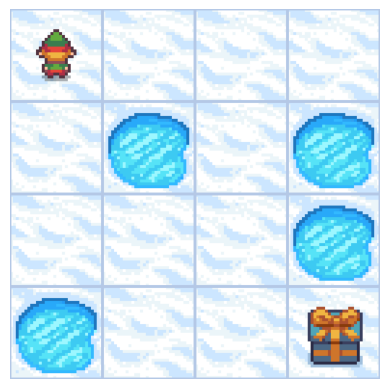

In [ ]:
env.reset()
# Visualize the agent's performance
visualize_agent(env, q_table, episodes=10, sleep_time=0, end_sleep_time=3)

#Clean up the environment
env.close()